In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import category_encoders as ce
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from geopy.distance import geodesic
from sklearn.svm import SVR

# Prepare Train & Validation Dataset

In [2]:
path_base = './data/clean_data_with_auxiliary_keep_duplicate_v3/train_numeric.csv'
path_norm = './data/clean_data_with_auxiliary_keep_duplicate_v3/train_aux_tar_norm.csv'
path_stand = './data/clean_data_with_auxiliary_keep_duplicate_v3/train_aux_tar_stand.csv'
path_final = './data/final-train.csv'

df_base = pd.read_csv(path_base)
df_norm_full = pd.read_csv(path_norm)
df_stand_full = pd.read_csv(path_stand)
df_final = pd.read_csv(path_final, index_col=0)

In [3]:
print(df_base.columns)
print(df_norm_full.columns)
print(df_stand_full.columns)
print(df_final.columns)

Index(['Unnamed: 0', 'bedrooms', 'bathrooms', 'lat', 'lng', 'since_built_year',
       'no_of_units', 'area_size', 'since_listing_month', 'price'],
      dtype='object')
Index(['closeness_closest_mrt', 'betweenness_closest_mrt', 'closest_comercial',
       'closest_hawker', 'closest_primary', 'closest_secondary',
       'closest_mall', 'closest_mrt', 'closeness_num_mrt_1.5km',
       'betweenness_num_mrt_1.5km', 'num_comercial_3km', 'num_hawker_1.5km',
       'num_primary_3km', 'num_secondary_3km', 'num_mall_2km', 'num_mrt_1.5km',
       'name', 'model', 'bedrooms', 'bathrooms', 'district', 'region',
       'planning_area', 'subszone', 'lat', 'lng', 'freehold',
       'since_built_year', 'no_of_units', 'area_size', 'since_listing_month',
       'additional_rooms', 'price'],
      dtype='object')
Index(['closeness_closest_mrt', 'betweenness_closest_mrt', 'closest_comercial',
       'closest_hawker', 'closest_primary', 'closest_secondary',
       'closest_mall', 'closest_mrt', 'closeness

In [4]:
## Only preserve target encoding + numeric data from original data souce (excluding auxilliary attributes)
preserved_columns = ['name', 'model', 'bedrooms', 'bathrooms', 'district', 'region',
       'planning_area', 'subszone', 'lat', 'lng', 'freehold',
       'since_built_year', 'no_of_units', 'area_size', 'since_listing_month',
       'additional_rooms', 'price']
df_norm_sub = df_norm_full.drop([col for col in df_norm_full if col not in preserved_columns], axis=1)
df_stand_sub = df_stand_full.drop([col for col in df_stand_full if col not in preserved_columns], axis=1)


In [4]:
X_base = df_base.drop(columns = ['price'])
y_base = df_base[['price']]

X_norm_sub = df_norm_sub.drop(columns = ['price'])
y_norm_sub = df_norm_sub[['price']]

X_stand_sub = df_stand_sub.drop(columns = ['price'])
y_stand_sub = df_stand_sub[['price']]

X_norm_full = df_norm_full.drop(columns = ['price'])
y_norm_full = df_norm_full[['price']]

X_stand_full = df_stand_full.drop(columns = ['price'])
y_stand_full = df_stand_full[['price']]

X_final = df_final.drop(columns = ['price'])
y_final = df_final[['price']]

In [6]:
X_base_train, X_base_val, y_base_train, y_base_val = train_test_split(X_base, y_base, test_size = 0.2, random_state = 100)

X_norm_sub_train, X_norm_sub_val, y_norm_sub_train, y_norm_sub_val = train_test_split(X_norm_sub, y_norm_sub, test_size = 0.2, random_state = 100)

X_stand_sub_train, X_stand_sub_val, y_stand_sub_train, y_stand_sub_val = train_test_split(X_stand_sub, y_stand_sub, test_size = 0.2, random_state = 100)

X_norm_full_train, X_norm_full_val, y_norm_full_train, y_norm_full_val = train_test_split(X_norm_full, y_norm_full, test_size = 0.2, random_state = 100)

X_stand_full_train, X_stand_full_val, y_stand_full_train, y_stand_sub_val = train_test_split(X_stand_full, y_stand_full, test_size = 0.2, random_state = 100)

X_final_train, X_final_val, y_final_train, y_final_val = train_test_split(X_final, y_final, test_size = 0.2, random_state = 100)


In [7]:
print(X_base_train.shape, X_base_val.shape, y_base_train.shape, y_base_val.shape)
print(X_norm_sub_train.shape, X_norm_sub_val.shape, y_norm_sub_train.shape, y_norm_sub_val.shape)
print(X_stand_sub_train.shape, X_stand_sub_val.shape, y_stand_sub_train.shape, y_stand_sub_val.shape)
print(X_norm_full_train.shape, X_norm_full_val.shape, y_norm_full_train.shape, y_norm_full_val.shape)
print(X_stand_full_train.shape, X_stand_full_val.shape, y_stand_full_train.shape, y_stand_sub_val.shape)
print(X_final_train.shape, X_final_val.shape, y_final_train.shape, y_final_val.shape)


(20822, 9) (5206, 9) (20822, 1) (5206, 1)
(20822, 16) (5206, 16) (20822, 1) (5206, 1)
(20822, 16) (5206, 16) (20822, 1) (5206, 1)
(20822, 32) (5206, 32) (20822, 1) (5206, 1)
(20822, 32) (5206, 32) (20822, 1) (5206, 1)
(20838, 28) (5210, 28) (20838, 1) (5210, 1)


# Build Model

In [8]:
X_trainset_ls = [X_base_train, X_norm_sub_train, X_stand_sub_train, X_norm_full_train, X_stand_full_train]
y_trainset_ls = [y_base_train, y_norm_sub_train, y_stand_sub_train, y_norm_full_train, y_stand_full_train]
X_valset_ls = [X_base_val, X_norm_sub_val, X_stand_sub_val, X_norm_full_val, X_stand_full_val]
y_valset_ls = [y_base_val, y_norm_sub_val, y_stand_sub_val, y_norm_full_val, y_stand_sub_val]

X_full_ls = [X_base, X_norm_sub, X_stand_sub, X_norm_full, X_stand_full]
y_full_ls = [y_base, y_norm_sub, y_stand_sub, y_norm_full, y_stand_full]

X_trainset_ls = [X_base_train, X_norm_sub_train, X_final_train]
y_trainset_ls = [y_base_train, y_norm_sub_train, y_final_train]

X_valset_ls = [X_base_val, X_norm_sub_val, X_final_val]
y_valset_ls = [y_base_val, y_norm_sub_val, y_final_val]

X_full_ls = [X_base, X_norm_sub, X_final]
y_full_ls = [y_base, y_norm_sub, y_final]

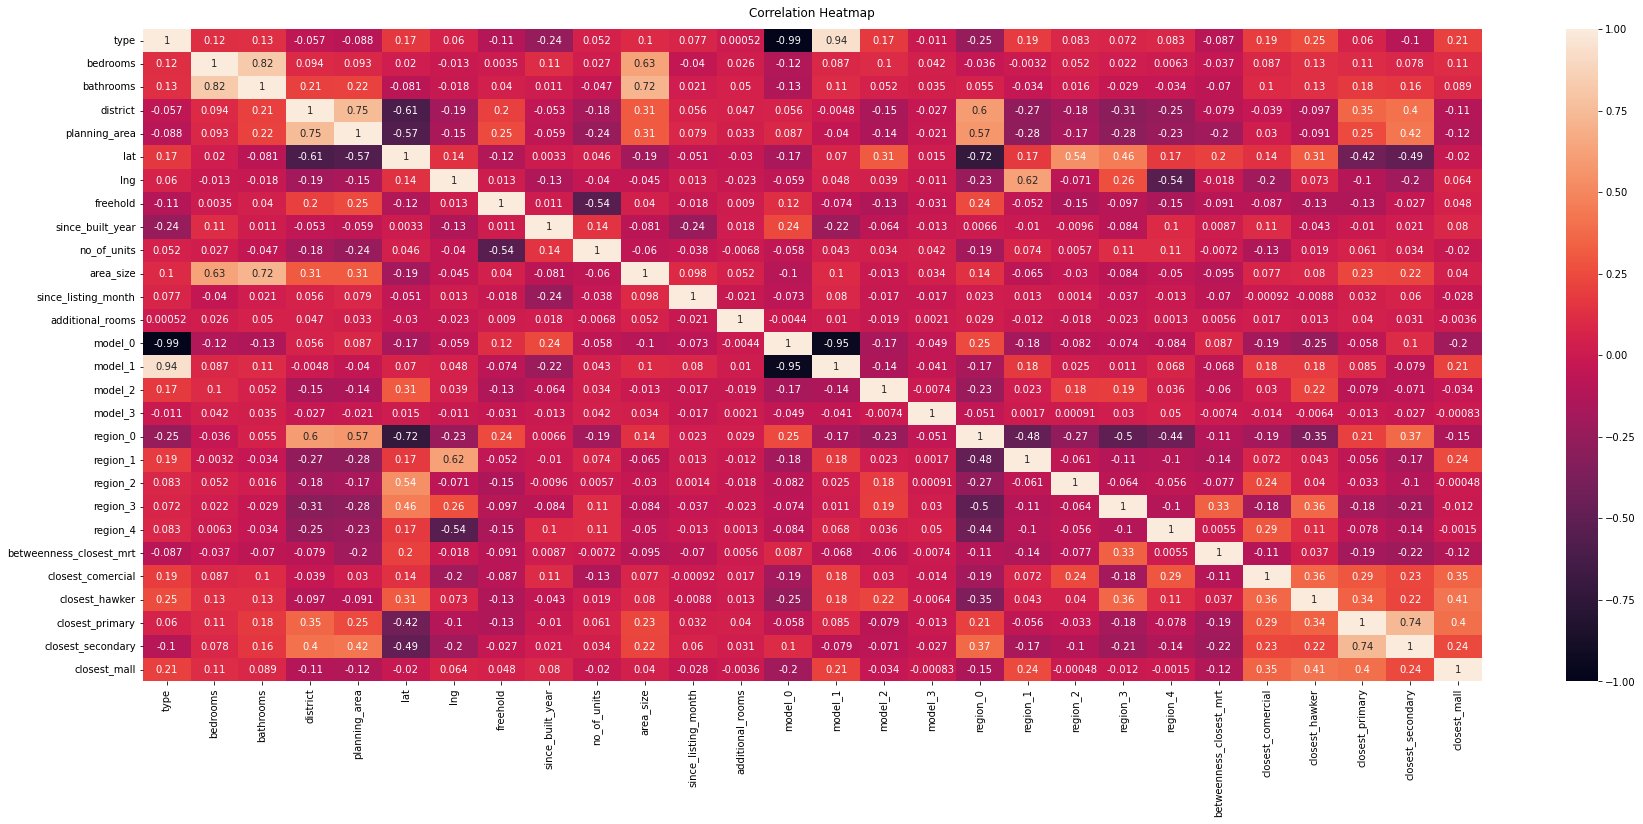

In [9]:
# show confusion matrix for current variables
# Increase the size of the heatmap.
plt.figure(figsize=(30, 12))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(X_final.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
X_final.columns

Index(['type', 'bedrooms', 'bathrooms', 'district', 'planning_area', 'lat',
       'lng', 'freehold', 'since_built_year', 'no_of_units', 'area_size',
       'since_listing_month', 'additional_rooms', 'model_0', 'model_1',
       'model_2', 'model_3', 'region_0', 'region_1', 'region_2', 'region_3',
       'region_4', 'betweenness_closest_mrt', 'closest_comercial',
       'closest_hawker', 'closest_primary', 'closest_secondary',
       'closest_mall'],
      dtype='object')

## Linear Regression

In [146]:
lm_r2 = []
lm_rmse = []
for i in range(3):
    lm = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    all_r2_scores = cross_val_score(lm, X_full_ls[i], y_full_ls[i], scoring='r2', cv=folds)
    all_rmse = cross_val_score(lm, X_full_ls[i], y_full_ls[i], scoring='neg_root_mean_squared_error', cv=folds)
    lm_r2.append(np.mean(all_r2_scores))
    lm_rmse.append(np.mean(all_rmse)*(-1))

In [147]:
print(lm_r2)
print(lm_rmse)

[0.7665118609185607, 0.8076570109024243, 0.803329095803561]
[1955048.4607459425, 1774758.7167635623, 1908868.3680004957]


## Support Vector Regression

In [84]:
# Cross validation so use full train dataset
# Prediction use validation set
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_base_train)
y = sc_y.fit_transform(y_base_train)
y = y.reshape(len(y),)
cv = KFold(n_splits=5, random_state=100, shuffle=True)
regressor = SVR(kernel='rbf')
all_r2_scores = cross_val_score(regressor, X, y,scoring='r2', cv=cv)
print("\nR2: ", all_r2_scores.mean())
regressor.fit(X,y)

# Validation Prediction
pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_base_val)).reshape(-1, 1))
rmse = float(format(np.sqrt(mean_squared_error(y_base_val, pred)), '.3f'))
print("\nRMSE: ", rmse)


R2:  0.8509598637641567

RMSE:  1391312.877


In [87]:
# Cross validation so use full train dataset
# Prediction use validation set
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_base_train)
y = sc_y.fit_transform(y_base_train)
y = y.reshape(len(y),)
cv = KFold(n_splits=5, random_state=100, shuffle=True)
regressor = SVR(kernel='rbf', C=10)
all_r2_scores = cross_val_score(regressor, X, y, cv=cv)
print("\nR2: ", all_r2_scores.mean())
regressor.fit(X,y)
# Validation Prediction
pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_base_val)).reshape(-1, 1))
rmse = float(format(np.sqrt(mean_squared_error(y_base_val, pred)), '.3f'))
print("\nRMSE: ", rmse)


R2:  0.9134643989468968

RMSE:  1115096.023


In [ ]:
# svr_r2 = []
# svr_rmse = []

In [148]:
svr_r2_v2 = []
svr_rmse_v2 = []
for i in range(3):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(X_trainset_ls[i])
    y = sc_y.fit_transform(y_trainset_ls[i])
    y = y.reshape(len(y),)
    cv = KFold(n_splits=5, random_state=100, shuffle=True)
    regressor = SVR(kernel='rbf', C=10)
    all_r2_scores = cross_val_score(regressor, X, y, scoring='r2', cv=cv)
    regressor.fit(X,y)
    pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_valset_ls[i])).reshape(-1, 1))
    rmse = float(format(np.sqrt(mean_squared_error(y_valset_ls[i], pred)), '.3f'))
    svr_r2_v2.append(np.mean(all_r2_scores))
    svr_rmse_v2.append(rmse)


In [89]:
print(svr_r2)
print(svr_rmse)

[0.9134643989468968, 0.9464803548114992, 0.9464799558765351, 0.9578101169470576, 0.9578101169470565]
[1115096.023, 1048694.599, 1048694.599, 812873.188, 812873.188]


In [149]:
print(svr_r2_v2)
print(svr_rmse_v2)

[0.9134643989468968, 0.9464803548114992, 0.9566989220982297]
[1115096.023, 1048694.599, 789341.875]


In [151]:
rmse

789341.875

In [152]:
base_r2_mean  = all_r2_scores.mean()
base_rmse = rmse
full_feature_dict = {}

for col in X_final_train.columns:
    print(col)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(X_final_train.drop(columns = [col]))
    y = sc_y.fit_transform(y_final_train)
    y = y.reshape(len(y),)
    cv = KFold(n_splits=5, random_state=100, shuffle=True)
    regressor = SVR(kernel='rbf', C = 10)
    all_r2_scores = cross_val_score(regressor, X, y, cv=cv)
    print("\nR2: ", all_r2_scores.mean())
    regressor.fit(X,y)
    pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_final_val.drop(columns = [col]))).reshape(-1, 1))
    rmse = float(format(np.sqrt(mean_squared_error(y_final_val, pred)), '.3f'))
    print("\nRMSE: ", rmse)  
    r2_diff =  all_r2_scores.mean() - base_r2_mean 
    rmse_diff = base_rmse - rmse
    full_feature_dict[col] = [r2_diff, rmse_diff]
    print("By removing {}: R2 improve {:5f}; RMSE imporve {:9f}".format(col, r2_diff, rmse_diff))


type

R2:  0.9563334758215731

RMSE:  793696.082
By removing type: R2 improve -0.000365; RMSE imporve -4354.207000
bedrooms

R2:  0.9562502644298057

RMSE:  797478.084
By removing bedrooms: R2 improve -0.000449; RMSE imporve -8136.209000
bathrooms

R2:  0.9575178302476772

RMSE:  752142.244
By removing bathrooms: R2 improve 0.000819; RMSE imporve 37199.631000
district

R2:  0.9557789273930484

RMSE:  804096.704
By removing district: R2 improve -0.000920; RMSE imporve -14754.829000
planning_area

R2:  0.9546362871881833

RMSE:  768110.087
By removing planning_area: R2 improve -0.002063; RMSE imporve 21231.788000
lat

R2:  0.9564100828186166

RMSE:  792124.568
By removing lat: R2 improve -0.000289; RMSE imporve -2782.693000
lng

R2:  0.9560288479253278

RMSE:  798256.623
By removing lng: R2 improve -0.000670; RMSE imporve -8914.748000
freehold

R2:  0.9541130559543671

RMSE:  824441.344
By removing freehold: R2 improve -0.002586; RMSE imporve -35099.469000
since_built_year

R2:  0.954835

In [153]:
svr_res = pd.DataFrame.from_dict(full_feature_dict, orient='index', columns = ['r2_diff', 'rmse_diff'])
svr_res.head()

,r2_diff,rmse_diff
type,-0.000365,-4354.207
bedrooms,-0.000449,-8136.209
bathrooms,0.000819,37199.631
district,-0.000920,-14754.829
planning_area,-0.002063,21231.788


In [154]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

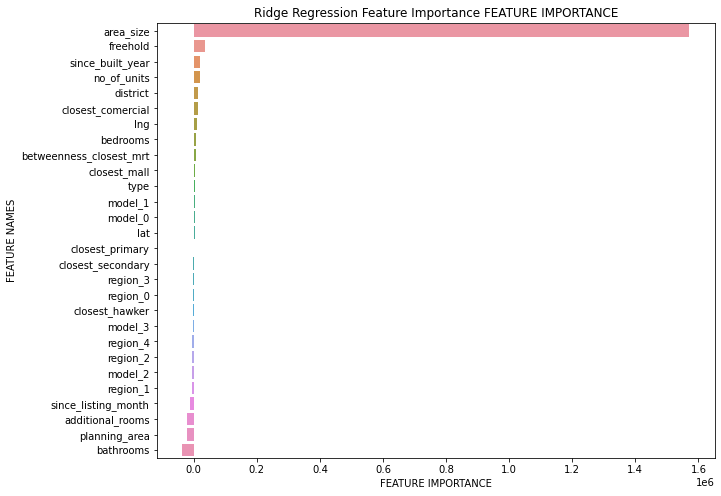

In [155]:
plot_feature_importance(svr_res.rmse_diff*-1,svr_res.index,'Ridge Regression Feature Importance')

In [9]:
# col_rm = ['subszone', 'since_listing_month', 'additional_rooms', 'bathrooms']
col_rm = ['since_listing_month', 'planning_area','additional_rooms', 'bathrooms', 'region_1', 'model_2']

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_final_train.drop(columns = col_rm))
y = sc_y.fit_transform(y_final_train)
y = y.reshape(len(y),)
cv = KFold(n_splits=5, random_state=100, shuffle=True)
regressor = SVR(kernel='rbf', C=10)
all_r2_scores = cross_val_score(regressor, X, y, cv=cv)
all_rmse = cross_val_score(regressor, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print("\nR2: ", all_r2_scores.mean())
regressor.fit(X,y)
all_rmse.mean()
# Validation Prediction
pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_final_val.drop(columns = col_rm))).reshape(-1, 1))
rmse = float(format(np.sqrt(mean_squared_error(y_final_val, pred)), '.3f'))
print("\nRMSE: ", rmse)

/home/nancyli/anaconda3/envs/CS5228/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nancyli/anaconda3/envs/CS5228/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nancyli/anaconda3/envs/CS5228/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nancyli/anaconda3/envs/CS5228/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was 


R2:  -0.07019041430007342


/home/nancyli/anaconda3/envs/CS5228/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-4446435.508549612

## Neural Network

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Use the most complete dataset
train_data_tensor = torch.tensor(X_final_train.values.astype(np.float32))
train_label_tensor = torch.tensor(y_final_train.values.astype(np.float32))
val_data_tensor = torch.tensor(X_final_val.values.astype(np.float32))
val_label_tensor = torch.tensor(y_final_val.values.astype(np.float32))
train_tensor = TensorDataset(train_data_tensor, train_label_tensor)
val_tensor = TensorDataset(val_data_tensor,val_label_tensor)

batch_size = 64
trainloader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(val_tensor, batch_size=batch_size, shuffle=True, num_workers=1)

In [12]:
examples = next(iter(trainloader))
examples[0].shape

torch.Size([64, 28])

In [17]:
class nn_Model(nn.Module):
    def __init__(self):
        super(nn_Model, self).__init__()
        self.sequence = nn.Sequential(
            nn.Linear(28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        out = self.sequence(x)
        return out

In [38]:
nn_model = nn_Model()
lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=lr)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 500
train_loss = []
val_loss = []

In [39]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += np.power(loss.item(), 0.5)
        if (i + 1) % 300 == 0:
            print('epoch {:3d} | {:5d} batches loss: {:.4f}'.format(epoch, i + 1, running_loss/300))
    
    train_loss.append(running_loss/i)
    outputs_val = nn_model(val_data_tensor)    
    loss_val = criterion(outputs_val, val_label_tensor)
    val_loss.append(np.power(loss_val.item(), 0.5))
    print('epoch {:3d} | val loss: {:.4f}'.format(epoch, np.power(loss_val.item(), 0.5)))


print('Finished Training')

epoch   0 |   300 batches loss: 3636761.5350
epoch   0 | val loss: 2766912.3309
epoch   1 |   300 batches loss: 2170232.3872
epoch   1 | val loss: 2247951.0288
epoch   2 |   300 batches loss: 1773852.1174
epoch   2 | val loss: 1761920.4789
epoch   3 |   300 batches loss: 1520725.6133
epoch   3 | val loss: 1510030.9678
epoch   4 |   300 batches loss: 1369657.2893
epoch   4 | val loss: 1425939.3033
epoch   5 |   300 batches loss: 1312074.6357
epoch   5 | val loss: 1385569.7231
epoch   6 |   300 batches loss: 1240379.5180
epoch   6 | val loss: 1327977.8358
epoch   7 |   300 batches loss: 1232477.7910
epoch   7 | val loss: 1326306.4270
epoch   8 |   300 batches loss: 1193449.8376
epoch   8 | val loss: 1327856.8729
epoch   9 |   300 batches loss: 1191799.7362
epoch   9 | val loss: 1256564.3630
epoch  10 |   300 batches loss: 1154401.8650
epoch  10 | val loss: 1241552.5995
epoch  11 |   300 batches loss: 1167473.1423
epoch  11 | val loss: 1233572.0671
epoch  12 |   300 batches loss: 1132045.

epoch 104 |   300 batches loss: 792758.6609
epoch 104 | val loss: 896449.4598
epoch 105 |   300 batches loss: 802446.8746
epoch 105 | val loss: 876139.7947
epoch 106 |   300 batches loss: 782449.0742
epoch 106 | val loss: 872020.8156
epoch 107 |   300 batches loss: 784087.8491
epoch 107 | val loss: 885284.9778
epoch 108 |   300 batches loss: 770868.0488
epoch 108 | val loss: 882942.6640
epoch 109 |   300 batches loss: 777774.0014
epoch 109 | val loss: 889844.4004
epoch 110 |   300 batches loss: 783103.2341
epoch 110 | val loss: 860685.8583
epoch 111 |   300 batches loss: 791745.2905
epoch 111 | val loss: 850890.2799
epoch 112 |   300 batches loss: 767430.0687
epoch 112 | val loss: 881369.8929
epoch 113 |   300 batches loss: 765961.3374
epoch 113 | val loss: 850794.7691
epoch 114 |   300 batches loss: 776079.1507
epoch 114 | val loss: 866362.4377
epoch 115 |   300 batches loss: 756463.2717
epoch 115 | val loss: 852144.5971
epoch 116 |   300 batches loss: 759216.2046
epoch 116 | val loss

epoch 210 |   300 batches loss: 655401.2158
epoch 210 | val loss: 766634.0920
epoch 211 |   300 batches loss: 633856.9288
epoch 211 | val loss: 769505.5962
epoch 212 |   300 batches loss: 641428.3336
epoch 212 | val loss: 810945.8966
epoch 213 |   300 batches loss: 642183.7202
epoch 213 | val loss: 759152.6230
epoch 214 |   300 batches loss: 649980.2392
epoch 214 | val loss: 758639.1873
epoch 215 |   300 batches loss: 637626.6992
epoch 215 | val loss: 753753.4295
epoch 216 |   300 batches loss: 643000.5668
epoch 216 | val loss: 757705.2088
epoch 217 |   300 batches loss: 641122.5528
epoch 217 | val loss: 757771.9350
epoch 218 |   300 batches loss: 626182.3766
epoch 218 | val loss: 757645.6562
epoch 219 |   300 batches loss: 642800.3514
epoch 219 | val loss: 748308.0558
epoch 220 |   300 batches loss: 636203.7939
epoch 220 | val loss: 819057.1475
epoch 221 |   300 batches loss: 649902.4929
epoch 221 | val loss: 773284.7718
epoch 222 |   300 batches loss: 627625.5652
epoch 222 | val loss

epoch 316 |   300 batches loss: 595945.6313
epoch 316 | val loss: 737049.8752
epoch 317 |   300 batches loss: 578705.5737
epoch 317 | val loss: 716778.1254
epoch 318 |   300 batches loss: 584530.7830
epoch 318 | val loss: 770491.0215
epoch 319 |   300 batches loss: 581010.2666
epoch 319 | val loss: 755860.1914
epoch 320 |   300 batches loss: 596367.7701
epoch 320 | val loss: 729798.6873
epoch 321 |   300 batches loss: 571410.0909
epoch 321 | val loss: 787790.4517
epoch 322 |   300 batches loss: 585496.1923
epoch 322 | val loss: 734506.7621
epoch 323 |   300 batches loss: 568552.4708
epoch 323 | val loss: 743391.2500
epoch 324 |   300 batches loss: 578629.4371
epoch 324 | val loss: 723144.0856
epoch 325 |   300 batches loss: 553439.0182
epoch 325 | val loss: 800465.7435
epoch 326 |   300 batches loss: 589632.4355
epoch 326 | val loss: 751272.0739
epoch 327 |   300 batches loss: 595009.5979
epoch 327 | val loss: 711708.6153
epoch 328 |   300 batches loss: 569866.0150
epoch 328 | val loss

epoch 422 |   300 batches loss: 544212.5097
epoch 422 | val loss: 711519.6366
epoch 423 |   300 batches loss: 529596.2392
epoch 423 | val loss: 727122.7897
epoch 424 |   300 batches loss: 533263.6521
epoch 424 | val loss: 715324.3096
epoch 425 |   300 batches loss: 533462.1726
epoch 425 | val loss: 750134.2124
epoch 426 |   300 batches loss: 525370.3217
epoch 426 | val loss: 747621.3411
epoch 427 |   300 batches loss: 528222.0208
epoch 427 | val loss: 730664.6548
epoch 428 |   300 batches loss: 550099.5356
epoch 428 | val loss: 717357.4061
epoch 429 |   300 batches loss: 533933.7390
epoch 429 | val loss: 731201.3416
epoch 430 |   300 batches loss: 530532.0320
epoch 430 | val loss: 717833.8373
epoch 431 |   300 batches loss: 541191.0361
epoch 431 | val loss: 724033.9206
epoch 432 |   300 batches loss: 537237.1255
epoch 432 | val loss: 802850.6115
epoch 433 |   300 batches loss: 534421.2159
epoch 433 | val loss: 769310.8812
epoch 434 |   300 batches loss: 530853.3579
epoch 434 | val loss

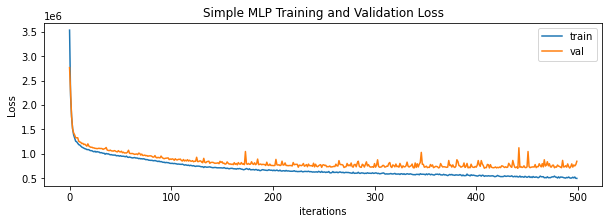

In [40]:
plt.figure(figsize=(10,3))
plt.title("Simple MLP Training and Validation Loss")
#plt.plot([i.detach().numpy() for i in val_loss],label="val")
plt.plot(train_loss,label="train")
plt.plot(val_loss,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Apply Model to Test Dataset

In [25]:
path_test = './data/final-test.csv'
test_df = pd.read_csv(path_test, index_col = 0)

In [ ]:
# SVR Prediction
col_rm = ['since_listing_month', 'planning_area','additional_rooms', 'bathrooms', 'region_1', 'model_2']
pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(test_df.drop(columns = col_rm))).reshape(-1, 1))


In [168]:
test_df.head()

,type,bedrooms,bathrooms,district,planning_area,lat,lng,freehold,since_built_year,no_of_units,...,region_1,region_2,region_3,region_4,betweenness_closest_mrt,closest_comercial,closest_hawker,closest_primary,closest_secondary,closest_mall
0,1,-0.496883,-0.244968,1.090614,-0.277340,0.341915,0.382426,1,1.252556,0.408840,...,0.0,0.0,0.0,0.0,0.138464,-0.142911,-0.766006,0.394425,0.118714,0.742840
1,1,0.410302,-0.244968,0.042179,-0.483629,0.272228,0.672597,1,-0.619332,-0.801538,...,0.0,0.0,0.0,0.0,-0.559139,0.582041,-0.716975,1.303927,-1.104269,0.452027
2,0,-1.404067,-1.114184,0.042179,-0.806896,0.361653,0.760150,1,-0.519053,-0.737207,...,1.0,0.0,0.0,0.0,-0.360056,-0.088743,-0.514987,0.232289,0.568633,1.357887
3,1,-0.496883,-1.114184,-1.001004,-0.912205,0.546606,0.963223,0,2.255354,-0.091513,...,1.0,0.0,0.0,0.0,-0.535067,0.044608,1.944232,-0.111140,-0.674561,2.892877
4,1,1.317486,3.231899,1.159573,0.794445,0.175666,0.547546,0,-0.652759,0.103863,...,0.0,0.0,0.0,0.0,-0.437737,-0.614000,-0.882432,0.580318,1.090210,-0.593629


In [169]:
np.arange(7500)

array([   0,    1,    2, ..., 7497, 7498, 7499])

In [170]:
pred_df = pd.DataFrame({'Id':np.arange(7500), 'Predicted': pred[:,0]})

In [171]:
pred_df.head()

,Id,Predicted
0,0,2.238797e+06
1,1,2.735994e+06
2,2,9.455591e+05
3,3,1.144307e+06
4,4,1.922981e+07


In [172]:
pred_df.to_csv('svr_final.csv', index=False)

In [26]:
# Neural network prediction
# Use the most complete dataset
test_data_tensor = torch.tensor(test_df.values.astype(np.float32))
print(test_data_tensor.shape)
# outputs = nn_model(inputs)

torch.Size([7500, 28])


In [27]:
nn_output = nn_model(test_data_tensor)

In [32]:
nn_pred = nn_output.detach().numpy()
nn_pred = pd.DataFrame(nn_pred)
nn_pred.to_csv('nn_final.csv')